In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve


C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}

dic1 = {'Yes':1,'No':0}

dic2 = {'In State':1,'Out of State':0}

dic3 = {'Owner':1,'1st Gen':0}

dic4 = {'Couple':1,'Single':0}

dic5 = {'Weekday':0, 'Weekend':1}


# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)

df['Homeowner']=df['Homeowner'].replace(dic1)

df['InState']=df['InState'].replace(dic2)

df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)

df['relationStatus']=df['relationStatus'].replace(dic4)

df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15761 entries, 146456 to 384973
Data columns (total 15 columns):
?TourContractGeneration       15761 non-null int64
?TourGeneration               15761 non-null int64
Age                           15761 non-null int64
AgentLine                     15761 non-null object
BookingWindow                 15761 non-null object
FirstGenVsOwner               15761 non-null int64
HHIncomeRanges                15761 non-null object
Homeowner                     15761 non-null int64
InState                       15761 non-null int64
Programs (Budget)             15761 non-null object
relationStatus                15761 non-null int64
ResultOfTour                  15761 non-null int64
TourSeason                    15761 non-null object
WeekdayOrWeekend              15761 non-null int64
NetVolumePlusNonGoodVolume    15761 non-null float64
dtypes: float64(1), int64(9), object(5)
memory usage: 1.9+ MB
None


In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek


dfX = df.drop(['ResultOfTour',   'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['AgentLine','BookingWindow',
       'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])


scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])
       

X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train


# define resampling method
resample = SMOTEENN(random_state=42, ratio = 'all')

dfX2, dfY2 = resample.fit_sample(dfX1, dfY1)
dfX2= pd.DataFrame(dfX2, columns = dfX.columns)
dfY2= pd.DataFrame(dfY2)

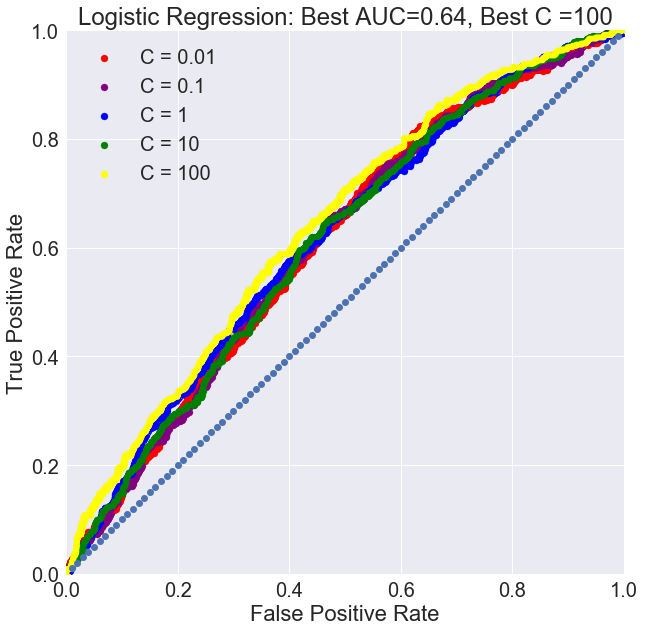

In [5]:


bestC = 0
bestAUCC = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    lr = LogisticRegression(C=Cs[i])
    lr.fit(xTrain,yTrain)
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCC:
        bestC=Cs[i]
        bestAUCC=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='C = '+str(Cs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('Logistic Regression: Best AUC='+str(round(bestAUCC,3))+', Best C ='+str(bestC))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

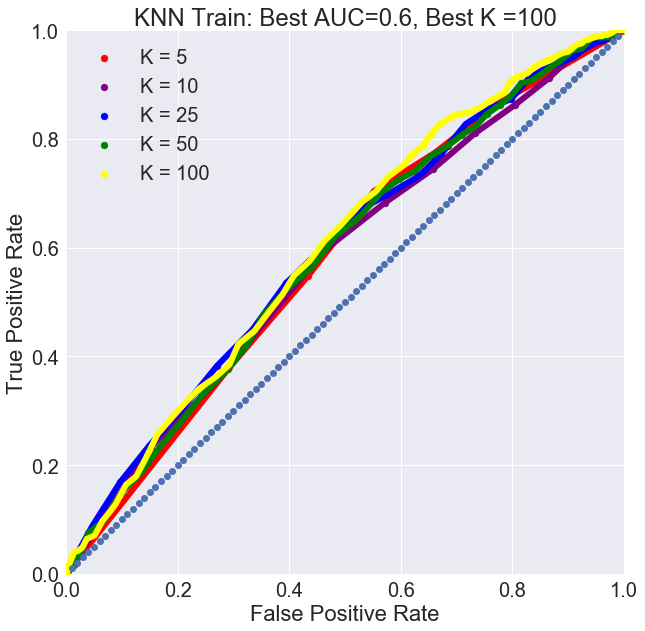

In [6]:
from sklearn.neighbors import KNeighborsClassifier


bestK = 0
bestAUCK = 0
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ks = [5,10,25,50,100]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)

#create oversampler

#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    knn = KNeighborsClassifier(Ks[i])
    knn.fit( xTrain , yTrain)
    preds = knn.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCK:
        bestK=Ks[i]
        bestAUCK=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='K = '+str(Ks[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('KNN Train: Best AUC='+str(round(bestAUCK,3))+', Best K ='+str(bestK))
plt.plot(x,y,'o')
plt.show()


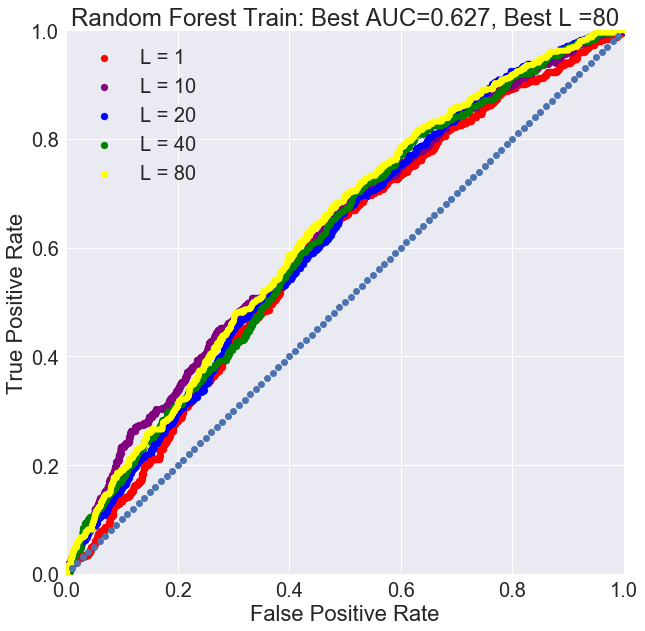

In [7]:
from sklearn.ensemble import RandomForestClassifier

bestL = 0
bestAUCL = 0
bestFeatureImportances= []
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ls = [1,10,20,40,80]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    rfr = RandomForestClassifier(n_estimators=1000,min_samples_leaf=Ls[i], random_state=42)
    rfr.fit(xTrain,yTrain)
    preds = rfr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCL:
        bestL=Ls[i]
        bestAUCL=auc
        bestFeatureImportances = rfr.feature_importances_
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='L = '+str(Ls[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('Random Forest Train: Best AUC='+str(round(bestAUCL,3))+', Best L ='+str(bestL))
plt.plot(x,y,'o')
plt.show()

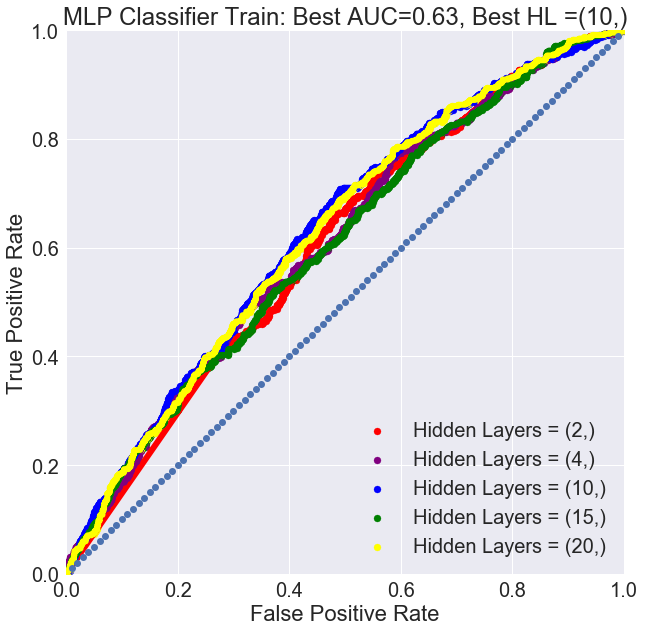

In [8]:
from sklearn.neural_network import MLPClassifier
import itertools 

bestHL = 0
bestAUCHL = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,4,10,15,20),repeat=1)]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    lr = MLPClassifier(hidden_layer_sizes=HLs[i])
    lr.fit(xTrain,yTrain)
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCHL:
        bestHL=HLs[i]
        bestAUCHL=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='Hidden Layers = '+str(HLs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('MLP Classifier Train: Best AUC='+str(round(bestAUCHL,3))+', Best HL ='+str(bestHL))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

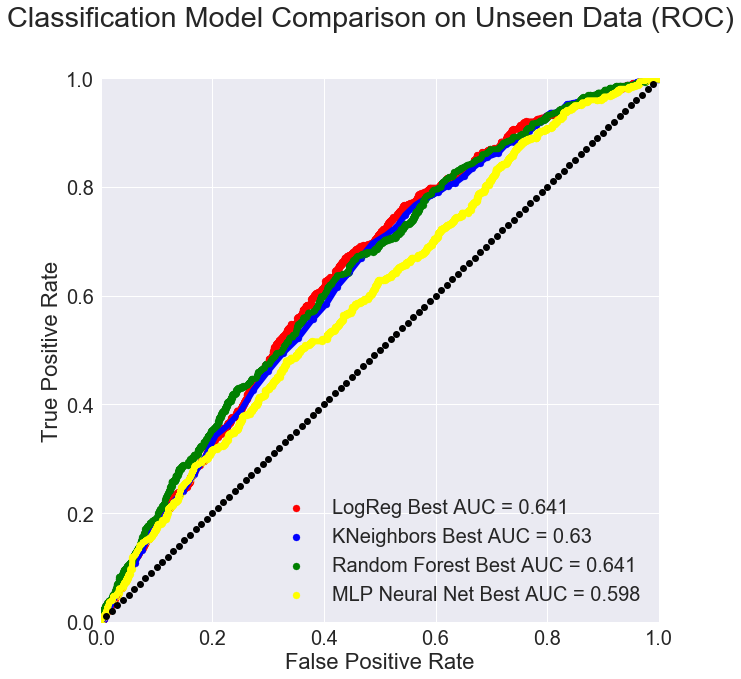

In [9]:
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX2,dfY2)
preds = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=fpr, y=tpr, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Red',linewidth=6.0)


#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX2,dfY2)
preds = knn.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Blue',linewidth=6.0)

#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42)
rf.fit(dfX2,dfY2)
preds = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier()
clf.fit(dfX2,dfY2)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Yellow',linewidth=6.0)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(x,y,'o', color='Black')
plt.suptitle('Classification Model Comparison on Unseen Data (ROC)')
plt.show()

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

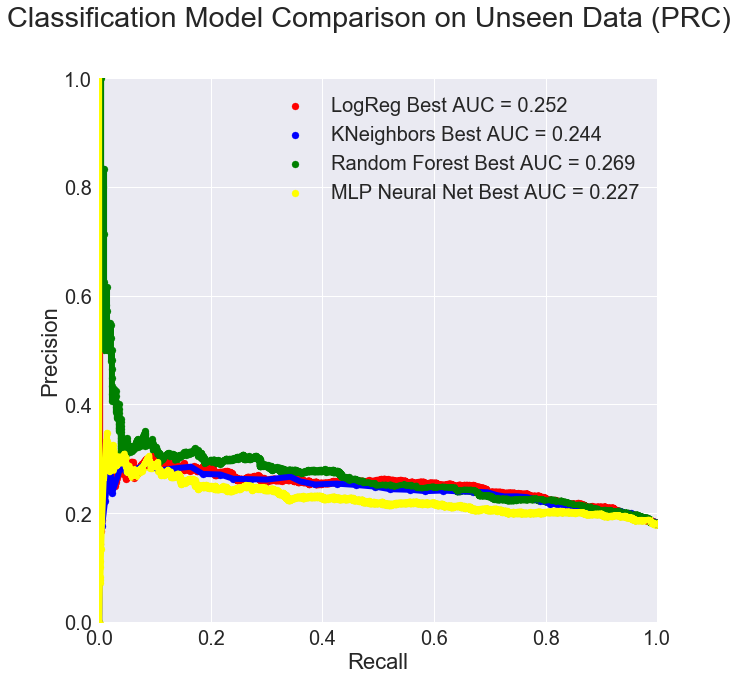

In [10]:
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX2,dfY2)
preds = lr.decision_function(X_test)
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=r, y=p, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Red',linewidth=6.0)



#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX2,dfY2)
preds = knn.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Blue',linewidth=6.0)

#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42)
rf.fit(dfX2,dfY2)
preds = rf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier()
clf.fit(dfX2,dfY2)
preds = clf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Yellow',linewidth=6.0)

x_mis = X_test[y_test !=rf.predict(X_test)]
x_mis['prediction'] = rf.predict(x_mis)
x_mis['actual'] = y_test[y_test != rf.predict(X_test)]

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.suptitle('Classification Model Comparison on Unseen Data (PRC)')
plt.show()

In [11]:

for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

0.136 ?TourGeneration
0.116 ?TourContractGeneration
0.11 InState
0.081 FirstGenVsOwner
0.07 Age
0.06 HHIncomeRanges_70k to 89k
0.052 WeekdayOrWeekend
0.05 relationStatus
0.032 AgentLine_Colorado
0.031 HHIncomeRanges_150k to 199k
0.027 AgentLine_Breck
0.027 HHIncomeRanges_90k to 149k
0.02 BookingWindow_Inside 90 days
0.016 HHIncomeRanges_200k to 349k
0.015 Programs (Budget)_(09) GL7 Inhouse
0.014 Programs (Budget)_(12) Outbound Telemarktng
0.013 Programs (Budget)_(06) GC8 Inhouse
0.013 TourSeason_Spring
0.011 TourSeason_Winter
0.01 BookingWindow_Inside Month
0.009 BookingWindow_Inside 2 Days
0.008 Programs (Budget)_(21) GTL In House
0.008 BookingWindow_Inside Year
0.008 Programs (Budget)_(17) Guest Member
0.007 HHIncomeRanges_Under 70k
0.006 TourSeason_Fall
0.006 Programs (Budget)_(14) Summit County OPC
0.006 BookingWindow_Inside Half Year
0.006 Programs (Budget)_(15) Internet
0.005 BookingWindow_Inside Week
0.005 TourSeason_Summer
0.005 HHIncomeRanges_350k to 500k
0.004 Homeowner
0.003

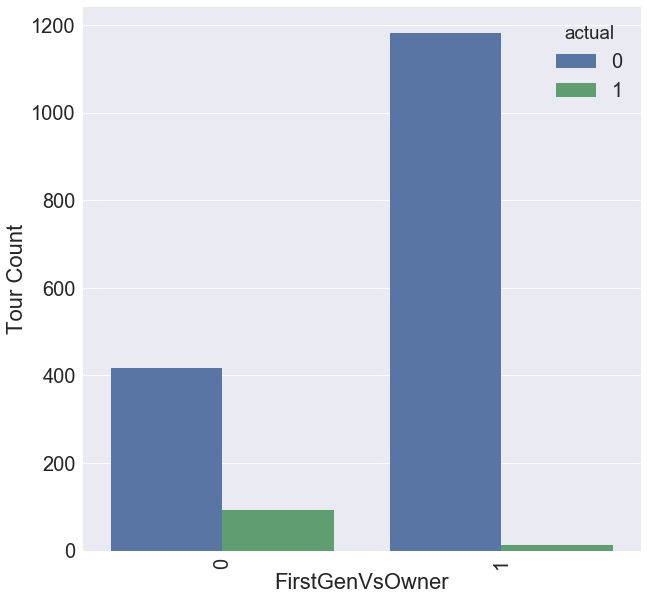

In [12]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'FirstGenVsOwner', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()

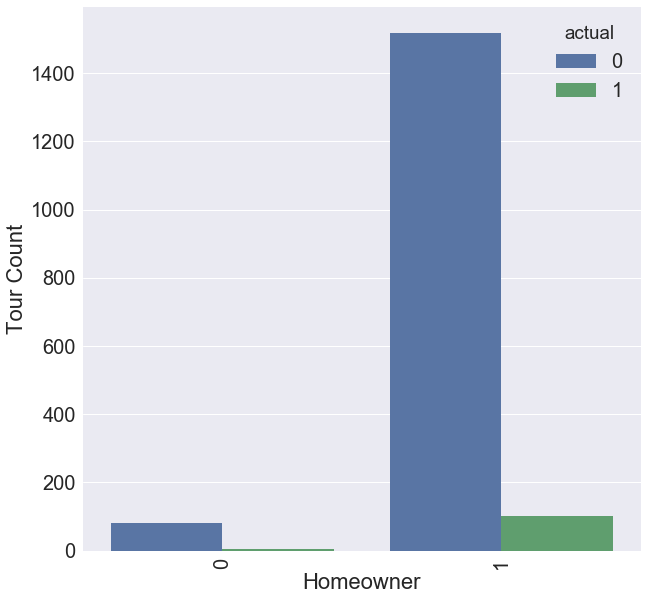

In [13]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'Homeowner', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()

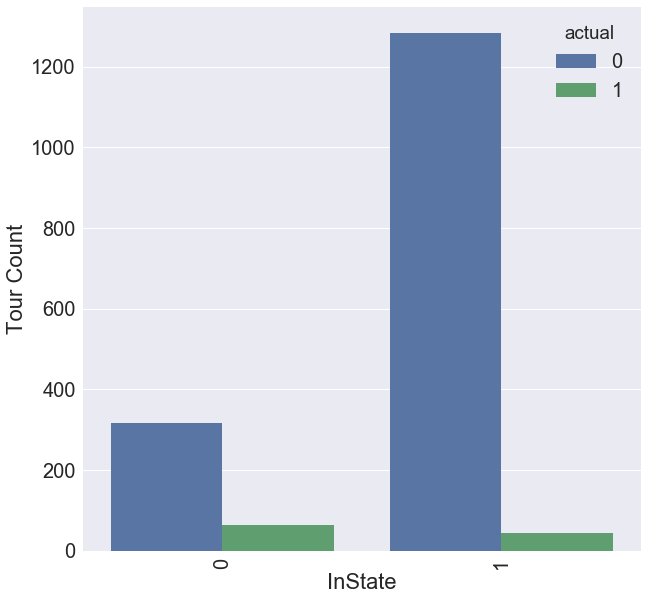

In [14]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'InState', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()

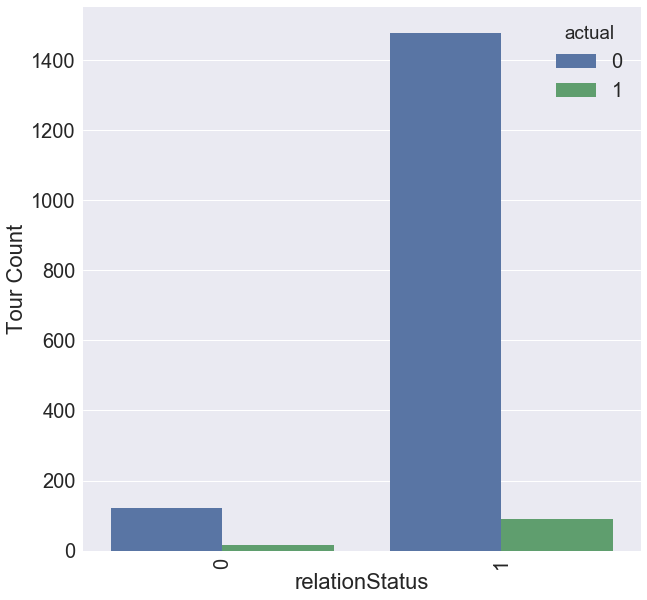

In [15]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'relationStatus', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()

In [16]:
print(len(x_mis['relationStatus']))

1706


In [17]:
print(len(X_test['relationStatus']))

3153


In [18]:
print(len(X_test['relationStatus'])-len(x_mis['relationStatus']))

1447


In [19]:
print(len(y_test[y_test == 1]))

566


In [20]:
print(len(x_mis[x_mis['actual']==1]))

106
